<a href="https://colab.research.google.com/github/anujsahani01/PyLoomer/blob/main/StarCoder_base_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [11]:
! pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=b52dc0611a9d3725bbe9577241189dfe9636f183a55482b74cd60e88e73c00ee
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [10]:
!pip install -q --upgrade bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install datasets
!pip install torch
!pip install evaluate
! pip install -U datasets huggingface-hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [12]:
import pandas as pd
import re
import transformers
print(transformers.__version__)
import huggingface_hub
from transformers import AutoTokenizer, AutoConfig
from transformers import AutoModelForCausalLM
from transformers import  Trainer, TrainingArguments
from accelerate import init_empty_weights,infer_auto_device_map
import torch
import evaluate
import torch
import numpy as np

4.34.0.dev0


In [13]:
from datasets import load_dataset

dataset = load_dataset("anujsahani01/Custom_Dataset_CodeGen")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 178487
    })
    validation: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 59496
    })
    test: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 59496
    })
})

In [5]:
train_prompts = dataset['train']['text_prompt']
test_prompts = dataset['test']['text_prompt']
validation_prompts = dataset['validation']['text_prompt']

train_code = dataset['train']['code_prompt']
test_code = dataset['test']['code_prompt']
validation_code = dataset['validation']['code_prompt']

print(len(train_prompts) == len(train_code))
print(len(test_prompts) == len(test_code))
print(len(validation_prompts) == len(validation_code))
print('----------------------------------------------')
print(None in train_prompts)
print(None in test_prompts)
print(None in validation_prompts)
print(None in train_code)
print(None in test_code)
print(None in validation_code)

True
True
True
----------------------------------------------
False
False
True
True
False
True


In [6]:
train_prompts = dataset['train']['text_prompt']
test_prompts = dataset['test']['text_prompt']
validation_prompts = dataset['validation']['text_prompt']

train_code = dataset['train']['code_prompt']
test_code = dataset['test']['code_prompt']
validation_code = dataset['validation']['code_prompt']

final_train_prompts = []
final_test_prompts = []
final_validation_prompts = []

final_train_code = []
final_test_code = []
final_validation_code = []

if None in train_prompts or None in train_code:
    for i in range(len(train_prompts)):
        if train_prompts[i] is not None and train_code[i] is not None:
            final_train_prompts.append(train_prompts[i])
            final_train_code.append(train_code[i])
else:
    final_train_prompts = train_prompts
    final_train_code = train_code

if None in test_prompts or None in test_code:
    for i in range(len(test_prompts)):
        if test_prompts[i] is not None and test_code[i] is not None:
            final_test_prompts.append(test_prompts[i])
            final_test_code.append(test_code[i])
else:
    final_test_prompts = test_prompts
    final_test_code = test_code

if None in validation_prompts or None in validation_code:
    for i in range(len(validation_prompts)):
        if validation_prompts[i] is not None and validation_code[i] is not None:
            final_validation_prompts.append(validation_prompts[i])
            final_validation_code.append(validation_code[i])
else:
    final_validation_prompts = validation_prompts
    final_validation_code = validation_code

In [7]:
print(None in final_train_prompts)
print(None in final_test_prompts)
print(None in final_validation_prompts)
print(None in final_train_code)
print(None in final_test_code)
print(None in final_validation_code)

False
False
False
False
False
False


In [8]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_val = pd.DataFrame()

df_train['text_prompt'] = final_train_prompts
df_train['code_prompt'] = final_train_code
df_test['text_prompt'] = final_test_prompts
df_test['code_prompt'] = final_test_code
df_val['text_prompt'] = final_validation_prompts
df_val['code_prompt'] = final_validation_code

In [9]:
from datasets import DatasetDict, Dataset

dataset = DatasetDict({
    'train' :  Dataset.from_pandas(df_train),
    'test' :  Dataset.from_pandas(df_test),
    'validation' :  Dataset.from_pandas(df_val)
})

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 178484
    })
    test: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 59496
    })
    validation: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 59495
    })
})

In [15]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

# special tokens for prompting
system_token = "<SYSTEM_TASK:>"
user_token = "<USER_TASK:>"
assistant_token = "<ASSISTANT_TASK:>"
end_token = "<END_TASK>"


tokenizer = AutoTokenizer.from_pretrained("bigcode/starcoderbase-1b",
                                          additional_special_tokens = ["<SYSTEM_TASK:>", "<USER_TASK:>", "<ASSISTANT_TASK:>", "<END_TASK>"],
                                          pad_token = "<PAD>",
                                          )

Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.


In [16]:
tokenizer

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


GPT2TokenizerFast(name_or_path='bigcode/starcoderbase-1b', vocab_size=49152, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<PAD>', 'additional_special_tokens': ['<SYSTEM_TASK:>', '<USER_TASK:>', '<ASSISTANT_TASK:>', '<END_TASK>']}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<fim_prefix>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<fim_middle>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<fim_suffix>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<fim_pad>", rstrip=False, lstrip=False, single_word=False, nor

In [17]:
special_token_dict = tokenizer.special_tokens_map
print(special_token_dict)

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


{'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<PAD>', 'additional_special_tokens': ['<SYSTEM_TASK:>', '<USER_TASK:>', '<ASSISTANT_TASK:>', '<END_TASK>']}


In [18]:
tokenizer.add_special_tokens(special_token_dict)

2

In [19]:
def dataset_LM(data):
    final = data['text_prompt'] + '\n' + data['code_prompt']
    return{
        'final_input' : final
    }

LM_final_dataset = dataset.map(dataset_LM, batched = False, remove_columns = dataset['train'].column_names)

LM_final_dataset

Map:   0%|          | 0/178484 [00:00<?, ? examples/s]

Map:   0%|          | 0/59496 [00:00<?, ? examples/s]

Map:   0%|          | 0/59495 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['final_input'],
        num_rows: 178484
    })
    test: Dataset({
        features: ['final_input'],
        num_rows: 59496
    })
    validation: Dataset({
        features: ['final_input'],
        num_rows: 59495
    })
})

In [20]:
context_length = 1000
def tokenize(data):
    return tokenizer(data['final_input'],
#                       padding = 'max_length',
                      truncation=True,)
#                       max_length = context_length)

tokenized_dataset = LM_final_dataset.map(tokenize, batched = True, remove_columns = LM_final_dataset['train'].column_names)

Map:   0%|          | 0/178484 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/59496 [00:00<?, ? examples/s]

Map:   0%|          | 0/59495 [00:00<?, ? examples/s]

In [21]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 178484
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 59496
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 59495
    })
})

In [22]:
print(len(tokenized_dataset['train'][10]['input_ids']))

231


In [23]:
block_size = 1000


def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [24]:
final_tokenized_dataset = tokenized_dataset.map(group_texts, batched = True)
final_tokenized_dataset

Map:   0%|          | 0/178484 [00:00<?, ? examples/s]

Map:   0%|          | 0/59496 [00:00<?, ? examples/s]

Map:   0%|          | 0/59495 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 41827
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 13984
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 40269
    })
})

In [12]:
import huggingface_hub
huggingface_hub.notebook_login()

In [14]:
! huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Your token has been saved in your

In [25]:
final_tokenized_dataset.push_to_hub('anujsahani01/StarCoder_tokenized')

Pushing dataset shards to the dataset hub:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/21 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/21 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/2 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/21 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/21 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/2 [00:00<?, ?it/s]

   **RESTART RUNTIME AS RAM IS FULL**

In [15]:
import pandas as pd
import re
import transformers
print(transformers.__version__)
import huggingface_hub
from transformers import AutoTokenizer, AutoConfig
from transformers import AutoModelForCausalLM
from transformers import  Trainer, TrainingArguments
from accelerate import init_empty_weights,infer_auto_device_map
import torch
import evaluate
import torch
import numpy as np

4.34.0.dev0


In [16]:
from datasets import load_dataset
final_tokenized_dataset = load_dataset("anujsahani01/StarCoder_tokenized")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/41827 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/13984 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/40269 [00:00<?, ? examples/s]

In [17]:
final_tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 41827
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 13984
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 40269
    })
})

In [21]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

# special tokens for prompting
system_token = "<SYSTEM_TASK:>"
user_token = "<USER_TASK:>"
assistant_token = "<ASSISTANT_TASK:>"
end_token = "<END_TASK>"


tokenizer = AutoTokenizer.from_pretrained("bigcode/starcoderbase-1b",
                                          additional_special_tokens = ["<SYSTEM_TASK:>", "<USER_TASK:>", "<ASSISTANT_TASK:>", "<END_TASK>"],
                                          pad_token = "<|PAD|>",
                                          model_max_length = 5000
                                          )

Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.


In [22]:
print(tokenizer)

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


GPT2TokenizerFast(name_or_path='bigcode/starcoderbase-1b', vocab_size=49152, model_max_length=5000, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|PAD|>', 'additional_special_tokens': ['<SYSTEM_TASK:>', '<USER_TASK:>', '<ASSISTANT_TASK:>', '<END_TASK>']}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<fim_prefix>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<fim_middle>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<fim_suffix>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<fim_pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=Tr

In [23]:
special_tokens = list(tokenizer.additional_special_tokens)
tokenizer.add_tokens(special_tokens)
print(tokenizer.vocab_size)

49152


In [24]:
len(tokenizer)

49157

In [25]:
context_length = 3000

In [26]:
config = AutoConfig.from_pretrained("bigcode/starcoderbase-1b",
                                    vocab_size= len(tokenizer),
                                    bos_token_id=tokenizer.bos_token_id,
                                    eos_token_id=tokenizer.eos_token_id,
                                    pad_token_id=tokenizer.pad_token_id,
                                    n_ctx = context_length,
                                    model_max_length = 3000
)

with init_empty_weights():
    model = AutoModelForCausalLM.from_config(config)

print(model)

GPTBigCodeForCausalLM(
  (transformer): GPTBigCodeModel(
    (wte): Embedding(49157, 2048)
    (wpe): Embedding(8192, 2048)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTBigCodeBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTBigCodeAttention(
          (c_attn): Linear(in_features=2048, out_features=2304, bias=True)
          (c_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTBigCodeMLP(
          (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
          (c_proj): Linear(in_features=8192, out_features=2048, bias=True)
          (act): PytorchGELUTanh()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((2048,), eps=1e

In [27]:
device_map = infer_auto_device_map(model, no_split_module_classes = ['GPT2Block'])
print(device_map)

{'': 0}


In [28]:
import torch
from transformers import BitsAndBytesConfig, AutoConfig

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16,
   n_ctx = context_length
)


model_id = "bigcode/starcoderbase-1b"
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            config = config,
                                            # device_map="auto",
                                            quantization_config=nf4_config,
                                            torch_dtype=torch.bfloat16)

In [29]:
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 49157. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(49157, 2048)

In [31]:
from transformers import GenerationConfig
prompts = dataset['test'][0:10]['text_prompt']
human_baseline_codes = dataset['test'][0:10]['code_prompt']

orignal_model_codes = []
generation_config = GenerationConfig(max_new_tokens=200, temperature= 0.5, do_sample=True, top_p = 5)

for _, prompt in enumerate(prompts):
    prompt = f"""
<SYSTEM_TASK:>\nGiven the following code description, write Python code to implement the functionality described below\n<END_TASK>\n<USER_TASK:>\nDescription:\n'
{prompt}
"""
    input = tokenizer(prompt, return_tensors="pt")
    orignal_model_outputs = model.generate(input['input_ids'], generation_config=generation_config ,  pad_token_id = tokenizer.pad_token_id)
    orignal_model_text_output = tokenizer.decode(orignal_model_outputs[0], skip_special_tokens=True)
    orignal_model_codes.append(orignal_model_text_output)

zipped_summaries = list(zip(human_baseline_codes, orignal_model_codes))
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_codes', 'orignal_model_codes'])
df

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1539: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


,human_baseline_codes,orignal_model_codes
0,\n self._log('get user orders')\n ...,"\n\nGiven the following code description, writ..."
1,\n self._log('get user trades')\n ...,"\n\nGiven the following code description, writ..."
2,\n amount = str(amount)\n self._...,"\n\nGiven the following code description, writ..."
3,\n amount = str(amount)\n price ...,"\n\nGiven the following code description, writ..."
4,\n # if the user has not logged in in 2...,"\n\nGiven the following code description, writ..."
5,\n login_return = self._is_logged_in()\...,"\n\nGiven the following code description, writ..."
6,\n login_return = self._is_logged_in()\...,"\n\nGiven the following code description, writ..."
7,"\n kwargs['key']=""requestPosition""\n ...","\n\nGiven the following code description, writ..."
8,\n try:\n return hv.NdLayout...,"\n\nGiven the following code description, writ..."
9,\n try:\n return hv.Layout(c...,"\n\nGiven the following code description, writ..."


In [32]:
rouge = evaluate.load('rouge')

In [33]:
orignal_model_results = rouge.compute(
    predictions=orignal_model_codes,
    references=human_baseline_codes[0:len(orignal_model_codes)],
    use_aggregator=True,
    use_stemmer=True,
)

print(orignal_model_results)

{'rouge1': 0.15204488082870954, 'rouge2': 0.031988451529927756, 'rougeL': 0.10484279468288554, 'rougeLsum': 0.14284764660081667}


In [34]:
from peft import get_peft_config, LoraConfig, TaskType, prepare_model_for_int8_training, get_peft_model
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [35]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=64,
    target_modules=["c_attn"],
    lora_dropout=0.4,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

In [36]:
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 49157. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(49157, 2048)

In [37]:
model.print_trainable_parameters()

trainable params: 835,584 || all params: 1,138,053,120 || trainable%: 0.07342223181989958


In [38]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [46]:
training_args = TrainingArguments(
    output_dir='./PyLoomer_starcoder',          # output directory
    num_train_epochs= 2,             # total number of training epochs
    per_device_train_batch_size=8,   # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=80,                # number of warmup steps for learning rate scheduler
    weight_decay=0.0001,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    learning_rate= 0.0001,
    max_steps = 8500,
    fp16= True,
    push_to_hub=True,
)

In [47]:
### Metrics
from datasets import load_metric
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [48]:
# import huggingface_hub
# huggingface_hub.notebook_login()

In [49]:
# ! huggingface-cli login

In [50]:
trainer = Trainer(
    model=model.to('cuda'),
    args=training_args,
    train_dataset=final_tokenized_dataset["train"],
    eval_dataset=final_tokenized_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )

In [51]:
model.config.use_cache = False

In [52]:
trainer.train()

Step,Training Loss
500,1.211700
1000,1.207500
1500,1.214300
2000,1.203700
2500,1.203000
3000,1.202400
3500,1.209600
4000,1.206000
4500,1.203500
5000,1.204100


TrainOutput(global_step=8500, training_loss=1.2041230612362133, metrics={'train_runtime': 7782.3446, 'train_samples_per_second': 8.738, 'train_steps_per_second': 1.092, 'total_flos': 4.1637514807296e+17, 'train_loss': 1.2041230612362133, 'epoch': 1.63})

In [53]:
# model.save_pretrained("anujsahani01/PyLoomer_CodeParrot")
# tokenizer.save_pretrained("anujsahani01/PyLoomer_CodeParrot")

In [54]:
metrics = trainer.state.log_history

In [55]:
train_loss = []
steps = []
for i in range(len(metrics)-1):
  train_loss.append(metrics[i]['loss'])
  steps.append(metrics[i]['step'])

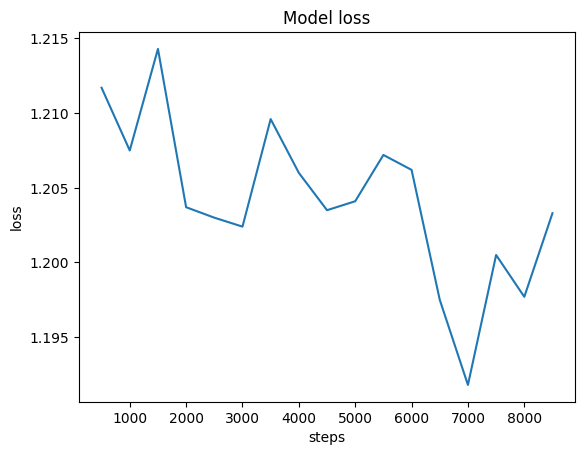

In [56]:
import matplotlib.pyplot as plt

plt.plot(steps, train_loss)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('steps')
plt.show()

In [57]:
trainer.push_to_hub()

'https://huggingface.co/anujsahani01/PyLoomer_starcoder/tree/main/'

In [58]:
from transformers import AutoModelForCausalLM, pipeline

model_ckpt = "anujsahani01/PyLoomer_starcoder"
model = AutoModelForCausalLM.from_pretrained(model_ckpt)

In [59]:
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 49157. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(49157, 2048)

In [61]:
tokenizer = AutoTokenizer.from_pretrained("anujsahani01/PyLoomer_starcoder",
                                          vocab_size = len(tokenizer),
                                          additional_special_tokens = ["<SYSTEM_TASK:>", "<USER_TASK:>", "<ASSISTANT_TASK:>", "<END_TASK>"],
                                          pad_token = "<PAD>",
                                          model_max_length = 3000
                                          )

print(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


GPT2TokenizerFast(name_or_path='anujsahani01/PyLoomer_starcoder', vocab_size=49152, model_max_length=3000, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<PAD>', 'additional_special_tokens': ['<SYSTEM_TASK:>', '<USER_TASK:>', '<ASSISTANT_TASK:>', '<END_TASK>']}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<fim_prefix>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	2: AddedToken("<fim_middle>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	3: AddedToken("<fim_suffix>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	4: AddedToken("<fim_pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, sp

In [62]:
add_prompt = '<SYSTEM_TASK:>\nGiven the following code description, write Python code to implement the functionality described below\n<END_TASK>\n<USER_TASK:>\nDescription:\n'
text_prompt = 'def VGG16_model_architecture()\n"""\nInitialize VGG16 model a deep learning model trained on imagenet for performing Image Classification in the VGG16_model_architecture function\n"""\n\bdef train_test_split():\n\t"""Split the data X, Y in to train and test data using sklearn"""\n\bdef model_predict():\n\t"""Make prediction using the deep learning model defined above in VGG16_model_architecture function"""\n'

final_prompt = add_prompt + text_prompt

In [63]:
# pad_token_id = tokenizer.pad_token_id

In [64]:
pipe = pipeline('text-generation', model = model_ckpt)
print(pipe(final_prompt, num_return_sequences=1, max_new_tokens = 150)[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


<SYSTEM_TASK:>
Given the following code description, write Python code to implement the functionality described below
<END_TASK>
<USER_TASK:>
Description:
def VGG16_model_architecture()
"""
Initialize VGG16 model a deep learning model trained on imagenet for performing Image Classification in the VGG16_model_architecture function
"""
def train_test_split():
	"""Split the data X, Y in to train and test data using sklearn"""
def model_predict():
	"""Make prediction using the deep learning model defined above in VGG16_model_architecture function"""
def model_evaluate():
	"""Evaluate the model performance using sklearn metrics"""
def model_save():
	"""Save the model to disk"""
def model_load():
	"""Load the model from disk"""
def model_predict_image():
	"""Make prediction using the model defined above in VGG16_model_architecture function"""
def model_evaluate_image():
	"""Evaluate the model performance using sklearn metrics"""
def model_save_image():
	"""Save the model to disk"""


In [71]:
from transformers import GenerationConfig
inputs = tokenizer(final_prompt, return_tensors = 'pt')
generation_config = GenerationConfig(max_new_tokens=500, temperature= 0.5, do_sample=True, top_p = 5)

output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens = 500,
        generation_config=generation_config,
        pad_token_id = tokenizer.pad_token_id,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{final_prompt}')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:
<SYSTEM_TASK:>
Given the following code description, write Python code to implement the functionality described below
<END_TASK>
<USER_TASK:>
Description:
def VGG16_model_architecture()
"""
Initialize VGG16 model a deep learning model trained on imagenet for performing Image Classification in the VGG16_model_architecture function
"""
def train_test_split():
	"""Split the data X, Y in to train and test data using sklearn"""
def model_predict():
	"""Make prediction using the deep learning model defined above in VGG16_model_architecture function"""

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
Given the following code description, write Python code to implement the functionality described belowDescription:
def VGG16_model_architecture()
"""
Initialize VGG16 model a deep learning model traine

In [67]:
rouge = evaluate.load('rouge')

In [68]:
model.config.pad_token_id = tokenizer.pad_token_id = tokenizer.unk_token_id

In [69]:
prompts = dataset['test'][0:10]['text_prompt']
human_baseline_codes = dataset['test'][0:10]['code_prompt']

finetuned_model_codes = []
generation_config = GenerationConfig(max_new_tokens=200, temperature= 0.5, do_sample=True, top_p = 5)

for _, prompt in enumerate(prompts):
    prompt = f"""
'<SYSTEM_TASK:>\nSolve the following problem using Python, implementing the functions described below, one line at a time\n<END_TASK>\n<USER_TASK:>\nDescription:\n'
{prompt}
"""
    input = tokenizer(prompt, return_tensors="pt")
    finetuned_model_outputs = model.generate(input['input_ids'], generation_config=generation_config ,  pad_token_id = tokenizer.pad_token_id)
    finetuned_model_text_output = tokenizer.decode(finetuned_model_outputs[0], skip_special_tokens=True)
    finetuned_model_codes.append(finetuned_model_text_output)

zipped_summaries = list(zip(human_baseline_codes, finetuned_model_codes))
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_codes', 'finetuned_model_codes'])
df

,human_baseline_codes,finetuned_model_codes
0,\n self._log('get user orders')\n ...,"\n'Solve the following problem using Python, i..."
1,\n self._log('get user trades')\n ...,"\n'Solve the following problem using Python, i..."
2,\n amount = str(amount)\n self._...,"\n'Solve the following problem using Python, i..."
3,\n amount = str(amount)\n price ...,"\n'Solve the following problem using Python, i..."
4,\n # if the user has not logged in in 2...,"\n'Solve the following problem using Python, i..."
5,\n login_return = self._is_logged_in()\...,"\n'Solve the following problem using Python, i..."
6,\n login_return = self._is_logged_in()\...,"\n'Solve the following problem using Python, i..."
7,"\n kwargs['key']=""requestPosition""\n ...","\n'Solve the following problem using Python, i..."
8,\n try:\n return hv.NdLayout...,"\n'Solve the following problem using Python, i..."
9,\n try:\n return hv.Layout(c...,"\n'Solve the following problem using Python, i..."


In [70]:
finetuned_model_results = rouge.compute(
    predictions=finetuned_model_codes,
    references=human_baseline_codes[0:len(finetuned_model_codes)],
    use_aggregator=True,
    use_stemmer=True,
)

print(finetuned_model_results)

{'rouge1': 0.17780926170351447, 'rouge2': 0.044132586273939095, 'rougeL': 0.12613717986660014, 'rougeLsum': 0.1628864780247748}


# **Rouge score for the fine-tuned model:**
Average Rouge = (Rouge-1 + Rouge-2 + Rouge-L + Rouge-Lsum) / 4

Average Rouge = (0.17780926170351447 + 0.044132586273939095 + 0.12613717986660014 + 0.1628864780247748) / 4

Average Rouge = 0.12799187671770788

Rouge score for the original model:
# **Average Rouge = (Rouge-1 + Rouge-2 + Rouge-L + Rouge-Lsum) / 4**
Average Rouge = (0.15204488082870954 + 0.031988451529927756 + 0.10484279468288554 + 0.14284764660081667) / 4

Average Rouge = 0.10743094391033462

Now, you can compare the average Rouge scores for both models:

Average Rouge for the fine-tuned model: 0.12799187671770788
Average Rouge for the original model: 0.10743094391033462

The fine-tuned model has a higher overall average Rouge score, so it performs better on average across Rouge-1, Rouge-2, Rouge-L, and Rouge-Lsum metrics.